# Generate Synthetic DTC Curve Using Available Log Data

## Import necessary modules

In [1]:
import lasio as ls
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None

## Pull in all las files that will be used to train and test model to predict DTC and create DataFrame

In [2]:
las_file_list = []
path = ''  # Add path to your las files that will be used to generate model

files = os.listdir(path)

for file in files:
    if file.lower().endswith('.las'):
        las_file_list.append(path + '\\' + file)

In [3]:
df_list=[]

for las in las_file_list:
    las = ls.read(las)
    lasdf = las.df()
    
    lasdf['WELL'] = las.well.WELL.value
    lasdf['DEPTH'] = lasdf.index
    df_list.append(lasdf)

# Master DataFrame containing all well data for multi-well analysis    
welldf = pd.concat(df_list,sort=True)

## Remove Depth as Index, filter to the core curves, and rename them to a common mnemonic
* Curve cleanup could be done before running this process or more efficiently coded into the program by using an alias table. Here all of this is done manually

In [4]:
welldf.reset_index(drop=True, inplace=True)
welldf.columns

Index(['BIT', 'BVOL', 'CAL', 'CALX', 'CGXT', 'CLDC', 'CNC', 'CTAO', 'CVOL',
       'DAZODQI', 'DCOR', 'DEN', 'DEPTH', 'DEVODQI', 'DPRL', 'DPWL', 'DT24AQI',
       'DT24QI', 'DTC', 'DTCQI', 'GGRM', 'GMPO', 'GMSG', 'GMTH', 'GMUR', 'GR',
       'GRGC', 'K', 'KTH', 'M0C6', 'M0R2', 'M0R6', 'M1R1', 'M1R2', 'M1R3',
       'M1R6', 'M1R9', 'M1RX', 'M2R1', 'M2R2', 'M2R3', 'M2R6', 'M2R9', 'M2RX',
       'MCDT', 'NPHI', 'NPHIL', 'NPRL', 'PDPE', 'PE', 'PORAQI', 'PORZ',
       'PORZC', 'R40T', 'R60T', 'R85T', 'RBODQI', 'RHOB', 'RT', 'RTAT', 'TEN',
       'TH', 'TTQI', 'U', 'WELL', 'WTBH', 'ZCOR', 'ZDEN', 'ZDNC'],
      dtype='object')

In [5]:
welldf = welldf.filter(['DEPTH','GR', 'GMSG', 'RT', 'RTAT', 'M2RX', 'NPHI', 'NPRL', 'NPHIL', 'CNC', 'RHOB', 'DEN', 'ZDNC', 'PE', 'PDPE', 'DTC', 'DT24QI', 'DTCQI', 'MCDT', 'WELL'])

In [6]:
welldf['DTC'] = welldf[['DTC', 'DT24QI', 'DTCQI', 'MCDT']].sum(1)
welldf.drop(['DT24QI', 'DTCQI', 'MCDT'], axis = 1, inplace=True)

welldf['GR'] = welldf[['GR','GMSG']].sum(1)
welldf.drop(['GMSG'], axis=1,inplace=True)

welldf['RT'] = welldf[['RT', 'RTAT', 'M2RX']].sum(1)
welldf.drop(['RTAT', 'M2RX'], axis=1,inplace=True)

welldf['PE'] = welldf[['PE', 'PDPE']].sum(1)
welldf.drop(['PDPE'], axis=1,inplace=True)

welldf['RHOB'] = welldf[['RHOB', 'DEN', 'ZDNC']].sum(1)
welldf.drop(['DEN', 'ZDNC'], axis=1,inplace=True)

welldf['NPHI'] = welldf[['NPHI', 'NPRL', 'NPHIL', 'CNC']].sum(1)
welldf.drop(['NPRL', 'NPHIL', 'CNC'], axis=1,inplace=True)

## Replace all 0 values that were previously NAN back to NAN and then filter the dataset to include only those rows that have all necessary curve information

In [7]:
welldf.replace(0,np.nan, inplace=True)
welldf2 = welldf.dropna(subset=['DEPTH','GR', 'RT', 'NPHI', 'RHOB','DTC'], axis=0, how='any')

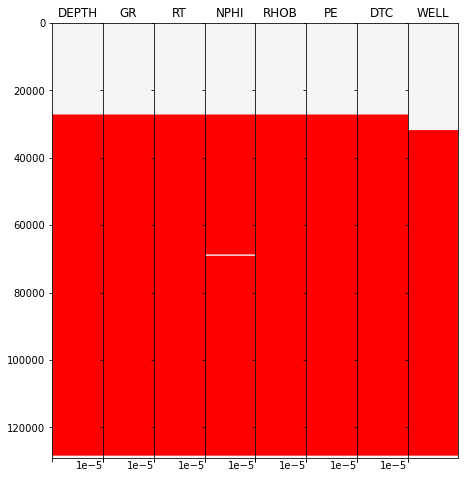

In [8]:
fig = plt.subplots(1,1, figsize=(10,8))

#Set up the plot axes
ax1 = plt.subplot2grid((1,11), (0,0), rowspan=1, colspan = 1) 
ax2 = plt.subplot2grid((1,11), (0,1), rowspan=1, colspan = 1)
ax3 = plt.subplot2grid((1,11), (0,2), rowspan=1, colspan = 1)
ax4 = plt.subplot2grid((1,11), (0,3), rowspan=1, colspan = 1)
ax5 = plt.subplot2grid((1,11), (0,4), rowspan=1, colspan = 1)
ax6 = plt.subplot2grid((1,11), (0,5), rowspan=1, colspan = 1)
ax7 = plt.subplot2grid((1,11), (0,6), rowspan=1, colspan = 1)
ax8 = plt.subplot2grid((1,11), (0,7), rowspan=1, colspan = 1)

columns = welldf2.columns
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

for i, ax in enumerate(axes):
    ax.plot(welldf2.iloc[:,i], welldf2.index, lw=0)
    ax.set_ylim(129005, 0)
    ax.set_xlim(0, 0.00001)
    ax.set_title(columns[i])
    ax.set_facecolor('whitesmoke')
    ax.fill_betweenx(welldf2.index, 0, welldf2.iloc[:,i], facecolor='red')
    # Remove tick labels from each subplot
    if i > 0:
        plt.setp(ax.get_yticklabels(), visible = False)
    plt.setp(ax.get_xticklabels(), visible = False)

plt.subplots_adjust(wspace=0)
plt.show()

## Import sklearn modules necessary for curve prediction.  In this example we will be using the Random Forest Regressor

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn import metrics

## Generate training and test datasets and then create the model

In [10]:
X = welldf2[['GR', 'RT', 'NPHI', 'RHOB', 'PE']]
y = welldf2['DTC']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [11]:
rf = RandomForestRegressor(n_estimators=1000)

In [12]:
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000)

In [13]:
rf_predictions = rf.predict(X_test) 

## Review model metrics to check for validity and then create a few plots to illustrate test results

In [14]:
print('Random Forest Regressor Metrics')
print('MAE:', metrics.mean_absolute_error(y_test, rf_predictions))
print('MSE:', metrics.mean_squared_error(y_test, rf_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rf_predictions)))
print('R2:', metrics.r2_score(y_test, rf_predictions))

Random Forest Regressor Metrics
MAE: 1.7375980279752947
MSE: 7.3580698667740645
RMSE: 2.7125762416518477
R2: 0.9548178959787876


In [15]:
rf_importance = rf.feature_importances_

In [16]:
welldf2['DTC_P'] = rf.predict(X)

Text(0.5, 1.0, 'Random Forest Attribute Importance')

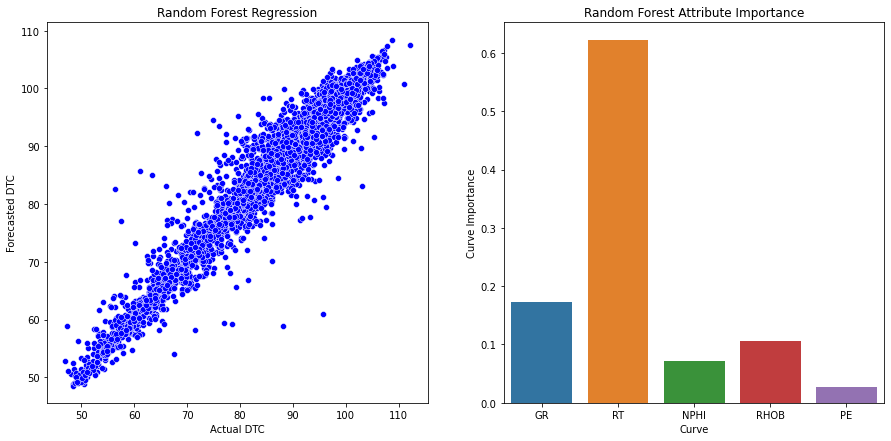

In [27]:
fig, axes = plt.subplots (1,2, figsize=(15,7))

sns.scatterplot(ax=axes[0], x = y_test, y = rf_predictions, color = 'blue')
axes[0].set_xlabel("Actual DTC")
axes[0].set_ylabel("Forecasted DTC")
axes[0].set_title('Random Forest Regression')

sns.barplot(ax=axes[1], x = X.columns, y = rf_importance)
axes[1].set_xlabel("Curve")
axes[1].set_ylabel("Curve Importance")
axes[1].set_title('Random Forest Attribute Importance')

>Results suggest that PE is not an important attribute which is good because that curve is generally absent from older logging runs.  Consider recreating a model without PE

## If the model looks good, it is time to load a new set of las files and convert to DataFrame to generate our DTC synthetics

In [18]:
example = ls.read('') # add path to the las file(s) where you want to create synthetic DTCP curve using model above

In [19]:
example = example.df()

## Curve aliasing isn't necessary here since I only loaded one well.  However, if you desire to generate synthetics across a field of wells then you will need to drop unnecessary curves and alias those that remain similar to what was done above

In [20]:
example.columns

Index(['GR', 'ILD', 'PE', 'RHOB', 'NPHI', 'DTCO'], dtype='object')

In [21]:
example['RT'] = example['ILD']
example['DTC'] = example['DTCO']
example['DEPTH'] = example.index
example.drop(['ILD','DTCO'], axis=1)
example = example[(example['DEPTH']>10000) & (example['DEPTH']<12400)]

In [22]:
example = example.dropna(subset=['GR', 'RT', 'NPHI', 'PE', 'RHOB'], axis=0, how='any')
example.columns

Index(['GR', 'ILD', 'PE', 'RHOB', 'NPHI', 'DTCO', 'RT', 'DTC', 'DEPTH'], dtype='object')

## Time to generate the synthetic DTC curve using the model created above.  Once synthetic curve is generated, save the results to the DataFrame to be plotted

In [23]:
example_x = example[['GR', 'RT', 'NPHI', 'PE', 'RHOB']]

In [24]:
example['DTCP'] = rf.predict(example_x)

## Results could be exported at this point to be viewed in your favorite G&G software package.  Here I will show the relationship between the real DTC curve and the synthetic curve generated from the model using matplotlib

In [25]:
def makeplot(depth, gamma, res, neut, dens, pe, dtc, dtcp, topdepth, bottomdepth):
    fig, ax = plt.subplots(figsize=(10,11))

    #Set up the plot axes
    ax1 = plt.subplot2grid((1,10), (0,0), rowspan=1, colspan = 2)
    ax2 = plt.subplot2grid((1,10), (0,2), rowspan=1, colspan = 2, sharey = ax1)
    ax3 = plt.subplot2grid((1,10), (0,4), rowspan=1, colspan = 2, sharey = ax1)
    ax4 = ax3.twiny()
    ax5 = ax3.twiny()
    ax6 = plt.subplot2grid((1,10), (0,6), rowspan=1, colspan = 2, sharey = ax1)
    ax7 = ax6.twiny()

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    ax10 = ax1.twiny()
    ax10.xaxis.set_visible(False)
    ax11 = ax2.twiny()
    ax11.xaxis.set_visible(False)
    ax12 = ax3.twiny()
    ax12.xaxis.set_visible(False)
    ax13 = ax6.twiny()
    ax13.xaxis.set_visible(False)
    ax14 = ax7.twiny()
    ax14.xaxis.set_visible(False)
            
    # Gamma ray track
    ax1.set_ylabel("Depth (ft)")
    ax1.plot(gamma, depth, color = "black", lw = 0.5)
    ax1.set_xlabel('GR')
    ax1.xaxis.label.set_color("black")
    ax1.set_xlim(0, 300)
    ax1.tick_params(axis='x', colors="black")
    ax1.spines["top"].set_edgecolor("black")
    ax1.set_xticks([0, 100, 200, 300])
    ax1.text(0.05, 1.02, 0, color='black', 
             horizontalalignment='left', transform=ax1.transAxes)
    ax1.text(0.95, 1.02, 300, color='black', 
              horizontalalignment='right', transform=ax1.transAxes)
    ax1.set_xticklabels([])
    

    ## Shading for GR  
    left_col_value = 0
    right_col_value = 200
    span = abs(left_col_value - right_col_value)
    cmap = plt.get_cmap('Greens')
    color_index = np.arange(left_col_value, right_col_value, span / 100)
    #loop through each value in the color_index
    for index in sorted(color_index):
        index_value = (index - left_col_value)/span
        color = cmap(index_value) #obtain color for color index value
        ax1.fill_betweenx(depth, 0 , gamma, where = gamma >= index,  color = color, alpha = 0.5)
    
    
    # Resistivity track
    ax2.plot(res, depth, color = "red", linewidth = 0.5)
    ax2.set_xlabel("ResD")
    ax2.set_xlim(0.2, 2000)
    ax2.xaxis.label.set_color("red")
    ax2.tick_params(axis='x', colors="red")
    ax2.spines["top"].set_edgecolor("red")
    ax2.set_xticks([0.1, 1, 10, 100, 1000])
    ax2.semilogx()
    ax2.text(0.05, 1.02, 0.1, color='red', 
             horizontalalignment='left', transform=ax2.transAxes)
    ax2.text(0.95, 1.02, 1000, color='red', 
             horizontalalignment='right', transform=ax2.transAxes)
    ax2.set_xticklabels([])

    # Density track
    ax3.plot(dens, depth, color = "black", linewidth = 0.5)
    ax3.set_xlabel("RHOB")
    ax3.set_xlim(1.95, 2.95)
    ax3.xaxis.label.set_color("black")
    ax3.tick_params(axis='x', colors="black")
    ax3.spines["top"].set_edgecolor("black")
    ax3.set_xticks([2, 2.25, 2.5, 2.75, 3])
    ax3.text(0.05, 1.02, 1.95, color='black', 
             horizontalalignment='left', transform=ax3.transAxes)
    ax3.text(0.95, 1.02, 2.95, color='black', 
             horizontalalignment='right', transform=ax3.transAxes)
    ax3.set_xticklabels([])

    # Neutron track placed ontop of density track
    ax4.plot(neut, depth, color = "blue", linewidth = 0.5)
    ax4.set_xlabel('NPHI')
    ax4.xaxis.set_label_coords(0.5, 1.085)
    ax4.xaxis.label.set_color("blue")
    ax4.set_xlim(.45, -.15)
    ax4.tick_params(axis='x', colors="blue")
    ax4.spines["top"].set_position(("axes", 1.06))
    ax4.spines["top"].set_visible(True)
    ax4.spines["top"].set_edgecolor("blue")
    ax4.set_xticks([.45,  .15, -.15])
    ax4.text(0.05, 1.07, .45, color='blue', 
             horizontalalignment='left', transform=ax4.transAxes)
    ax4.text(0.95, 1.07, -.15, color='blue', 
              horizontalalignment='right', transform=ax4.transAxes)
    ax4.set_xticklabels([])
    
    # Adding in neutron density shading
    x1=dens
    x2=neut

    x = np.array(ax3.get_xlim())
    z = np.array(ax4.get_xlim())

    nz=((x2-np.max(z))/(np.min(z)-np.max(z)))*(np.max(x)-np.min(x))+np.min(x)

    ax3.fill_betweenx(depth, x1, nz, where=x1>=nz, interpolate=True, color='grey')
    ax3.fill_betweenx(depth, x1, nz, where=x1<=nz, interpolate=True, color='red')
    
    # PE track placed ontop of neutron track
    ax5.plot(pe, depth, color = "black", linewidth = 0.5, ls = '--')
    ax5.set_xlabel('PE')
    ax5.xaxis.set_label_coords(0.5, 1.125)
    ax5.xaxis.label.set_color("black")
    ax5.set_xlim(0, 10)
    ax5.tick_params(axis='x', colors="black")
    ax5.spines["top"].set_position(("axes", 1.11))
    ax5.spines["top"].set_visible(True)
    ax5.spines["top"].set_edgecolor("black")
    ax5.set_xticks([0, 2, 4])
    ax5.text(0.05, 1.12, 0, color='black', 
             horizontalalignment='left', transform=ax5.transAxes)
    ax5.text(0.95, 1.12, 10, color='black', 
              horizontalalignment='right', transform=ax5.transAxes)
    ax5.set_xticklabels([])
    
    # DTC track
    ax6.plot(dtc, depth, color = "gray", linewidth = 0.5, ls = '--')
    ax6.set_xlabel("DTC")
    ax6.set_xlim(140, 40)
    ax6.xaxis.label.set_color("gray")
    ax6.tick_params(axis='x', colors="gray")
    ax6.spines["top"].set_edgecolor("gray")
    ax6.set_xticks([140, 120, 100, 80, 60, 40])
    ax6.text(0.05, 1.02, 140, color='gray', 
             horizontalalignment='left', transform=ax6.transAxes)
    ax6.text(0.95, 1.02, 40, color='gray', 
             horizontalalignment='right', transform=ax6.transAxes)
    ax6.set_xticklabels([])
    
    # DTCP track placed ontop of DTC track
    ax7.plot(dtcp, depth, color = "purple", linewidth = 0.5)
    ax7.set_xlabel('DTCP')
    ax7.xaxis.set_label_coords(0.5, 1.085)
    ax7.xaxis.label.set_color("purple")
    ax7.set_xlim(140, 40)
    ax7.tick_params(axis='x', colors="purple")
    ax7.spines["top"].set_position(("axes", 1.06))
    ax7.spines["top"].set_visible(True)
    ax7.spines["top"].set_edgecolor("purple")
    ax7.set_xticks([140, 120, 100, 80, 60, 40])
    ax7.text(0.05, 1.07, 140, color='purple', 
             horizontalalignment='left', transform=ax7.transAxes)
    ax7.text(0.95, 1.07, 40, color='purple', 
              horizontalalignment='right', transform=ax7.transAxes)
    ax7.set_xticklabels([])
    
    # Common functions for setting up the plot can be extracted into
    # a for loop. This saves repeating code.
    for ax in [ax1, ax2, ax3, ax6]:
        ax.set_ylim(bottomdepth, topdepth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_coords(0.5, 1.045)
        ax.spines["top"].set_position(("axes", 1.01))

    for ax in [ax2, ax3, ax4, ax5, ax6, ax7]:
        plt.setp(ax.get_yticklabels(), visible = False)
    
    plt.tight_layout()
    fig.subplots_adjust(wspace = 0)

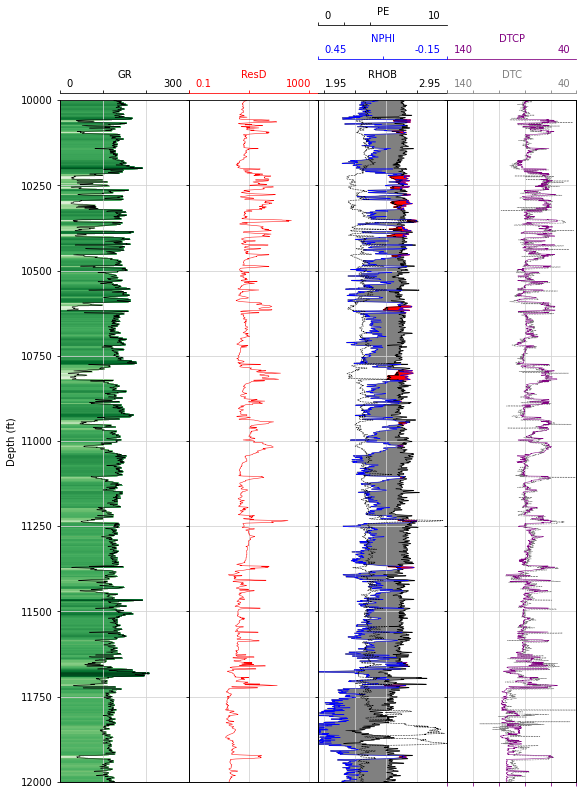

In [26]:
makeplot(example['DEPTH'], example['GR'], example['RT'], example['NPHI'],
        example['RHOB'], example['PE'], example['DTC'], example['DTCP'],
         10000, 12000)

>Actual (DTC) vs synthetic (DTCP) looks very similar and likely good enough for future log evaluations in those situations where a DTC curve is needed